In [3]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import requests
import time
from adjustText import adjust_text


# Import the .csv file as a DataFrame
sourcepath=Path("Resources/winemag-data.csv")
df_wine_nan=pd.read_csv(sourcepath)

df_wine_nan.count()

country        280833
description    280901
designation    197701
points         280901
price          258210
province       280833
region_1       234594
region_2       111464
variety        280900
winery         280901
dtype: int64

In [19]:
#Drop NaN rows from the following columns
df_wine=df_wine_nan.dropna(subset=['country','province','price','variety']) 
df_wine.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [20]:
#Drop duplicate rows 
df_wine.drop_duplicates(inplace=True)
df_wine.count()

C:\Users\arlen.CORP\AppData\Local\Continuum\anaconda3\envs\pythondata\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


country        157633
description    157633
designation    110755
points         157633
price          157633
province       157633
region_1       132009
region_2        67318
variety        157633
winery         157633
dtype: int64

In [21]:
df_mean=pd.DataFrame(df_wine.groupby(['country','province'],as_index=False).mean()).rename(columns = {'points':'avg points',
                                                                                       'price':'avg price'})
df_mean.head()

,country,province,avg points,avg price
0,Albania,Mirditë,88.000000,20.000000
1,Argentina,Mendoza Province,86.553467,23.420609
2,Argentina,Other,85.807453,21.211180
3,Armenia,Armenia,87.500000,14.500000
4,Australia,Australia Other,85.031315,11.814196


In [ ]:
df_mean['Lat'] = ""
df_mean['Lng'] = ""
df_mean.head()

In [ ]:
gkey="Your Google API"


def geoCodeLocation(country, province):
    '''
    Calculate Lat/Lng based on country and province
    '''
    try:
        target_city = f"{country}, {province}"
        target_url = 'https://maps.googleapis.com/maps/api/geocode/json?address={0}&key={1}'.format(target_city, gkey)
        geo_data = requests.get(target_url).json()
        print(target_url)
        lat = geo_data["results"][0]["geometry"]["location"]["lat"]
        lng = geo_data["results"][0]["geometry"]["location"]["lng"]
        return (lat,lng)
    except (KeyError, IndexError):
        return (0,0)

df_mean['Lat'],df_mean['Lng'] = zip(*df_mean.apply(lambda row: geoCodeLocation(row['country'], row['province']), axis=1))


In [ ]:
df_mean.head()

In [25]:
#Save clean data into csv file
df_mean.to_csv("Resources/winemag-mean_noDups_Coordinates.csv", encoding='utf-8',index=False)

In [4]:
#Reading csv file and Analysing data
sourcepath=Path("Resources/winemag-mean_noDups_Coordinates.csv")
df_wine=pd.read_csv(sourcepath)

df_wine=df_wine[df_wine['Lat']!=0]
df_wine.head()

#Top 10 Expensive Wines
df_wine_exp=df_wine.sort_values('avg price',ascending=False).head(10)

#USA
df_wine_us=df_wine[df_wine['country']=='US']
df_wine_us

#Get rows which are NOT in other dataframe
#All Other Wines
df_wine_other=df_wine[~df_wine.isin(df_wine_exp)].dropna()
df_wine_other=df_wine_other[~df_wine_other.isin(df_wine_us)].dropna()

df_wine_other.head()

,country,province,avg points,avg price,Lat,Lng
0,Albania,Mirditë,88.000000,20.000000,41.764286,19.902051
1,Argentina,Mendoza Province,86.553467,23.420609,-32.889625,-68.852687
2,Argentina,Other,85.807453,21.211180,-38.416097,-63.616672
3,Armenia,Armenia,87.500000,14.500000,40.069099,45.038189
4,Australia,Australia Other,85.031315,11.814196,-31.951269,115.865997


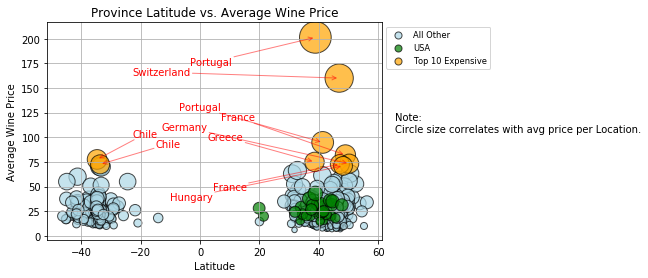

In [8]:
# Build a scatter plot
blue_line =plt.scatter(df_wine_other["Lat"], df_wine_other["avg price"],s=df_wine_other["avg price"]*5,
            marker="o",facecolors="lightblue",alpha=0.7, edgecolors="black",label="All Other")

green_line =plt.scatter(df_wine_us["Lat"], df_wine_us["avg price"],s=df_wine_us["avg price"]*5,
            marker="o",facecolors="green",alpha=0.7, edgecolors="black",label="USA")

orange_line=plt.scatter(df_wine_exp["Lat"], df_wine_exp["avg price"],s=df_wine_exp["avg price"]*5,
            marker="o",facecolors="orange",alpha=0.7, edgecolors="black",label="Top 10 Expensive")


labels = df_wine_exp['country']
texts = []
for x, y, text in zip(df_wine_exp["Lat"], df_wine_exp["avg price"], labels):
    texts.append(plt.text(x, y, text,color = 'red'))

adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(5,5), expand_text=(1,1), 
            arrowprops=dict(arrowstyle="->",color='r', connectionstyle='arc3,rad=0',alpha=0.5))  
    
# Incorporate the other graph properties
plt.title("Province Latitude vs. Average Wine Price")
plt.ylabel("Average Wine Price")
plt.xlabel("Latitude")
plt.text(0.93, 0.5, 'Note:\nCircle size correlates with avg price per Location.', fontsize=10, transform=plt.gcf().transFigure)

legend=plt.legend(handles=[blue_line,green_line, orange_line],loc="upper left", fontsize='small', fancybox=True, bbox_to_anchor=(1,1))
for legend_handle in legend.legendHandles:
    legend_handle._sizes=[50]
    
plt.grid(True)
# Save the figure
plt.savefig("output_data/Province Latitude vs. Average Wine Price Plot.png",dpi=300, bbox_inches = "tight")

# Show plot
plt.show()

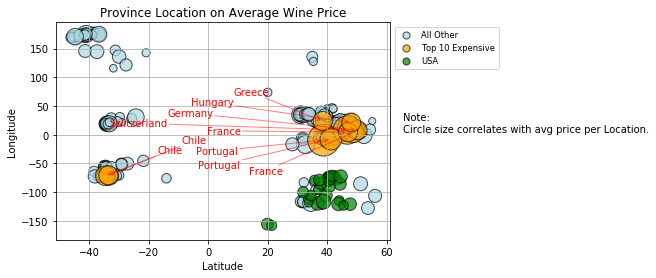

,country,province,avg price
317,Portugal,Colares,201.333333
433,Switzerland,Switzerland,160.000000
327,Portugal,Moscatel do Douro,94.750000
131,France,Champagne,82.073295
104,Chile,Santa Cruz,77.500000
174,Greece,Evia,75.000000
152,Germany,Rheingau,73.207824
130,France,Burgundy,72.771912
96,Chile,Puente Alto,72.500000
232,Hungary,Tokaji,70.941176


In [12]:
# Build a scatter plot
blue_line=plt.scatter(df_wine_other["Lat"], df_wine_other["Lng"],s=df_wine_other["avg price"]*5,
                      marker="o",facecolors="lightblue",alpha=0.7, edgecolors="black",label="All Other")

green_line =plt.scatter(df_wine_us["Lat"], df_wine_us["Lng"],s=df_wine_us["avg price"]*5,
            marker="o",facecolors="green",alpha=0.7, edgecolors="black",label="USA")

orange_line=plt.scatter(df_wine_exp["Lat"], df_wine_exp["Lng"],s=df_wine_exp["avg price"]*5,
                      marker="o",facecolors="orange",alpha=0.7, edgecolors="black",label="Top 10 Expensive")

# Incorporate the other graph properties
plt.title("Province Location on Average Wine Price")
plt.ylabel("Longitude")
plt.xlabel("Latitude")

plt.text(0.93, 0.5, 'Note:\nCircle size correlates with avg price per Location.', fontsize=10, transform=plt.gcf().transFigure)

texts = []
for x, y, text in zip(df_wine_exp["Lat"], df_wine_exp["Lng"], labels):
    texts.append(plt.text(x, y, text,color = 'red'))
                
    
adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(5,5), expand_text=(1,1), 
            arrowprops=dict(arrowstyle="->",color='r', connectionstyle='arc3,rad=0',alpha=0.5))

legend=plt.legend(handles=[blue_line, orange_line,green_line],loc="upper left", fontsize='small', fancybox=True, bbox_to_anchor=(1,1))
for legend_handle in legend.legendHandles:
    legend_handle._sizes=[50]
 
plt.grid(True)
# Save the figure
plt.savefig("output_data/Province Location on Average Wine Price Plot.png",dpi=300, bbox_inches = "tight")

# Show plot
plt.show()

df_wine_exp[['country','province','avg price']]

In [7]:
from pytrends.request import TrendReq

# Login to Google. Only need to run this once, the rest of requests will use the same session.
pytrend = TrendReq()
kw_list=['wine','winery','variety']
pytrend.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')

#interest_over_time_df = pytrend.interest_over_time()
#interest_over_time_df.sort_values('date',ascending=False).head(10)

# Get Google Keyword Suggestions
#suggestions_dict = pytrend.suggestions(keyword='wine')
#print(suggestions_dict)

# Interest by Region
# Returns data for where the keyword is most searched as shown on Google Trends' Interest by Region section.
interest_by_region_df = pytrend.interest_by_region()


interest_by_region_df = pytrend.interest_by_region()
interest_by_region_df.reset_index(inplace=True)

#interest_by_region_df=interest_by_region_df[interest_by_region_df['geoName'].isin(df_wine_exp['country'])]

interest_by_region_df.sort_values('wine',ascending=False).head()


,geoName,wine,winery,variety
236,United Kingdom,95,1,4
29,Brazil,94,4,2
75,France,93,4,3
60,Denmark,93,5,2
196,South Africa,93,4,3


In [7]:
points = pd.read_csv("Resources/winemag-data.csv", index_col=0)

#Drop NaN rows from the following columns
#Drop duplicate rows 
points=points.dropna(subset=['points','price']).drop_duplicates() 
points.head()

,description,designation,points,price,province,region_1,region_2,variety,winery
country,,,,,,,,,
US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [8]:
#https://www.winespectator.com/display/show/id/scoring-scale
#95-100 Classic: a great wine
#90-94 Outstanding: a wine of superior character and style
#85-89 Very good: a wine with special qualities
#80-84 Good: a solid, well-made wine
#75-79 Mediocre: a drinkable wine that may have minor flaws
#50-74 Not recommended

points_bins = [80,85,90,95,100]
group_names = ["Good", "Very good", "Outstanding", "Classic"]

points_count = points \
                        .groupby(pd.cut(points["points"], points_bins, labels=group_names)) \
                        .count()['points']

points_count

points
Good           31003
Very good      88066
Outstanding    36751
Classic         1118
Name: points, dtype: int64

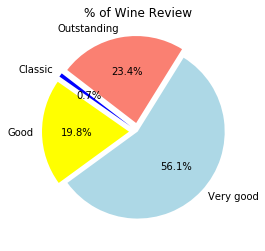

In [13]:
# Build Pie Chart
explode = (0.1, 0,0.1, 0.1)

plt.pie(points_count,explode=explode,autopct='%1.1f%%',
        labels=points_count.index,colors=["yellow", "lightblue", "salmon","Blue"],
        shadow=False, startangle=145)
plt.title("% of Wine Review")

# Save Figure
plt.savefig("output_data/Wine Review.png",dpi=300, bbox_inches = "tight")

# Show plot
plt.show()

In [10]:
points_mean = points \
                        .groupby(pd.cut(points["points"], points_bins, labels=group_names)) \
                        .mean()['price']

points_mean

points
Good            19.287843
Very good       28.855290
Outstanding     57.458056
Classic        180.889088
Name: price, dtype: float64

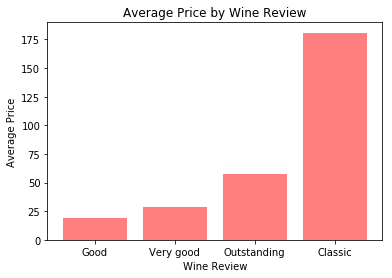

In [12]:
# Create a bar chart based upon the above data
plt.bar(group_names, points_mean, color='r', alpha=0.5, align="center")

plt.title("Average Price by Wine Review")
plt.ylabel("Average Price")
plt.xlabel("Wine Review")

# Save Figure
plt.savefig("output_data/Average Price by Wine Review.png",dpi=300, bbox_inches = "tight")

# Show plot
plt.show()